This notebooks showcases the steps taken to achieve accuracy of 79% while fine tuning BERT to assign scores to textual reviews.
Meanwhile we chose to inspire out work by notebook provided by Mohan (2023) on Kaggle available under the link: https://www.kaggle.com/code/neerajmohan/fine-tuning-bert-for-text-classification#Aproach,
this notebook provides much more in depth analysis of our work as well as showcases our own decisions, changes and further implementation.
The dataset used for such experiment is available here: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews and focuses on Amazon Book Reviews published by Bekheet (2022)

In [1]:
#intalling what we will be using
!pip install contractions
!python -m spacy download en_core_web_sm
!pip install transformers
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
#importing everything that we will need
from transformers import BertConfig, BertModel, BertTokenizer
import contractions
import os
import pandas as pd
import re
import spacy
import string #importing the punctuation list
import torch
import seaborn as sns
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from transformers import BertForSequenceClassification
from torch.optim import Adam
from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [16]:
#importing the original dataset and creating a one taking into account only the 2 columns we will need
!gdown "1VoCKo_UjqjaZFlgZeAIYlhEj4XKLEnvW&confirm=t"
df = pd.read_csv("/notebooks/Books_rating.csv") 
#review/text, review/score
df_rele = df[['review/score','review/text']].copy()
#printing out the head to check how it looks
df_rele.head()

Downloading...
From: https://drive.google.com/uc?id=1VoCKo_UjqjaZFlgZeAIYlhEj4XKLEnvW&confirm=t
To: /notebooks/Books_rating.csv
100%|██████████████████████████████████████| 2.86G/2.86G [00:41<00:00, 68.7MB/s]


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/Dataset/Books_rating.csv'

In [3]:
#converting the column consisting of reviews into string to ensure there is no numerical data
df_rele['review/text'] = df_rele['review/text'].astype('string')
print(df_rele.dtypes)
#dropping the empty rows
df_rele = df_rele.dropna(axis = 0)

NameError: name 'df_rele' is not defined

In [ ]:
#creating a preprocessing function
#removing punctuation, spaces, emojis, and any extras- fix contractions (can't = cannot)
def preprocesor (row):
  row['review/text'] = row['review/text'].lower() #making everything lowercase
  row['review/text'] = contractions.fix(row['review/text'])
  punctuation_trans = str.maketrans({x : ' ' for x in string.punctuation}) #x just a variable, for every bit of punctuation add a new key value pair (punctuation mapping to a space). It means we want every punctuation to be replaced by a space
  row['review/text'] = row['review/text'].translate(punctuation_trans) #removing punctuation
  row['review/text'] = re.sub(r"\s{2,}", " ", row['review/text'])
  return row

In [ ]:
#applying the preprocessed funtion onto the reviews
df_preprocessed = df_rele.apply(preprocesor, axis = 1)
df_preprocessed.to_csv('/content/drive/MyDrive/Dataset/preprocessed_reviews.csv', index = False)

In [ ]:
nlp = spacy.load('en_core_web_sm', disable = ['parser','ner']) #loading the nlp pipe
df_preprocessed = pd.read_csv('/content/drive/MyDrive/Dataset/preprocessed_reviews.csv') #loading the preprocessed dataset
docs = nlp.pipe(df_preprocessed['review/text'].to_list(), n_process = -1) #lemmetising #parsing the whole column through , -1 means do the max possible
lemma_reviews = []
for doc in docs: #looping through the doc created for each review
  #for each token(word) we wanna get the lemmatisation of it and .join joins it into a sentence together
  lemma_reviews.append(" ".join([token.lemma_ for token in doc if token.is_stop == False]))

df_preprocessed['review/text'] = lemma_reviews #overwriting
df_preprocessed.to_csv('/content/drive/MyDrive/Dataset/lemmatised_reviews.csv', index = False)

In [3]:
#configurating BERT
configuration = BertConfig()
#defining the model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels-5 for 5 different scores.
                    
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
#setting the tokeniser we will be using
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
#defining a device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cuda', index=0)

In [ ]:
#removing the empty rows after preproccesing and lemmatising (some of the reviews got empied due to their nature)
df = df.dropna(axis = 0)
print(df)
df.to_csv('/content/drive/MyDrive/Dataset/final_dataset.csv', index = False)


         review/score                                        review/text
0                 4.0  julie strain fan collection photo 80 page wort...
1                 5.0  care dr seuss read philip nel s book change mi...
2                 5.0  people book read child father man dr seuss the...
3                 4.0  theodore seuss geisel 1904 1991 aka quot dr se...
4                 4.0  philip nel dr seuss american iconthis basicall...
...               ...                                                ...
2999987           4.0  extremely difficult book digest casual reader ...
2999988           4.0  pretty interesting collingwood like historian ...
2999989           4.0  good book esoteric history e h carr easy selec...
2999990           5.0  daughter freshman indiana university e mail li...
2999991           1.0  guy good idea reader beware transciption diffe...

[2999973 rows x 2 columns]


In [32]:
#checking the lengths of the reviews
df = pd.read_csv("/notebooks/final_dataset.csv")
#maximum lenght of a review
lengths = []

#looping through each row.
for index, row in df.iterrows():

    # tokenising the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(row['review/text'], add_special_tokens=True)

    # updating the maximum sentence length.
    lengths.append(len(input_ids))


Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

<Axes: ylabel='Count'>

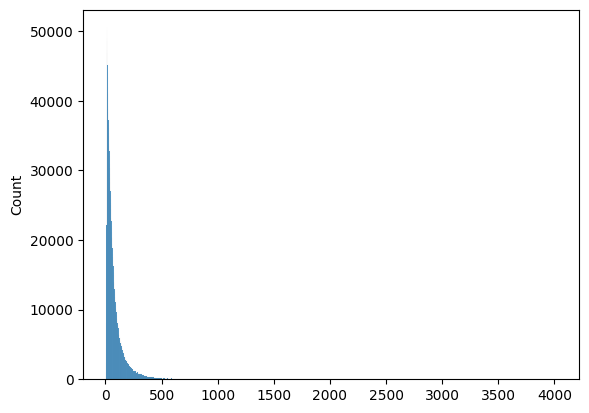

In [ ]:
#visualising the lengths
sns.histplot(lengths) 

In [5]:
#tokanisation
df = pd.read_csv("/notebooks/final_dataset.csv")

input_ids = []
attention_masks = []
#getting embeddings

for index,row in df.iterrows():
    
    encoded_dict = tokenizer.encode_plus(
                        row['review/text'],                      #what we will be encoding
                        add_special_tokens = True, # adding BERTs special tokens of [CLS] and [SEP]
                        max_length = 256,    #setting the maxiumum. lenghts so we can pad or truncate depending on the legth of each review
                        pad_to_max_length = True,
                        return_attention_mask = True,   # constructing attention masks
                        return_tensors = 'pt',     # returning pytorch tensors
                   )

    # adding the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])

    # and its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# converting the created lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# printing the first original sentence 0, as well as in form of ids
print('Original: ', df['review/text'].iloc[0])
print('Token IDs:', input_ids[0])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


KeyboardInterrupt: 

In [8]:
#saving input_ids and attention masks for later
torch.save(input_ids, "/notebooks/input_ids256.pt")
torch.save(attention_masks, "/notebooks/attention_masks256.pt")

In [14]:
#checking how many examples are in each class
df_grouped=df.groupby(['review/score']).count()
print(df_grouped)

              review/text
review/score             
1.0                201687
2.0                151058
3.0                254295
4.0                585614
5.0               1807319


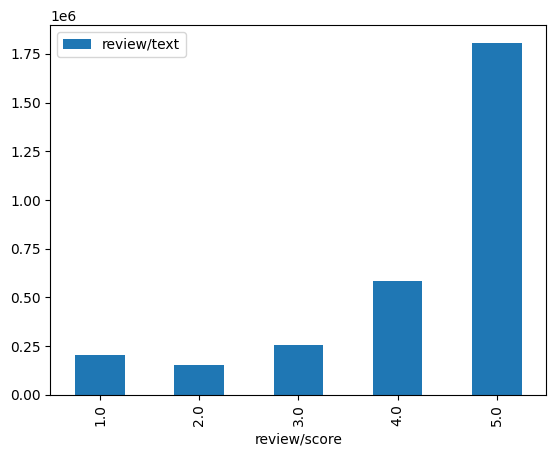

In [36]:
#visualising the dataset and seeing how many examples are for each class
df_grouped.plot.bar()
plt.show()

In [ ]:
#implementing one hot encoding on labels as well as making the dataset proportionate
#defining dataloaders
df = pd.read_csv('/notebooks/final_dataset.csv')
input_ids = torch.load('/notebooks/input_ids256.pt')
attention_masks = torch.load('/notebooks/attention_masks256.pt')

#converting labels to int
labels = torch.tensor(df['review/score'].astype(int).values)

enc = OneHotEncoder(handle_unknown='ignore')
labels_enc = torch.Tensor(enc.fit_transform([[x] for x in labels]).toarray())

#taking 60,000 examples of each category from the previously cleaned and preprocessed dataset

final_dataset_indices = torch.Tensor()
for label in range(1,6):
    label_indices = (labels==label).nonzero() #condition giving a true or false value depending if its met
    #getting first 60 000 samples
    sample_indices = label_indices[0:60000]
    final_dataset_indices = torch.cat((final_dataset_indices, sample_indices)) 
    print(final_dataset_indices.shape)
    
indices_long = final_dataset_indices.long()    
dataset = TensorDataset(input_ids[indices_long], attention_masks[indices_long], labels_enc[indices_long])  

In [9]:
#seeding (seed value) is a way of controlling what random sample I get- it is a random order but I am getting the same random order every time- it's easier to know since if i make a change to it I will know how it affected the batch because it is the SAME batch each time
seed_val = 77
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [ ]:
# creating a 80-20 train-validation split.
#!!!!!! 70 training 20 test 10 validation
# calculating the number of samples to include in each set
train_size = int(0.7 * len(dataset))
validation_size = int(0.1 * len(dataset))
test_size = len(dataset)  - train_size - validation_size

# dividing the dataset by randomly selecting samples.
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))
print('{:>5,} testing samples'.format(test_size))

In [ ]:
#dataloaders
#specifying the batch size for training
#for using BERT a batch size of 16 or 32 is recommended 
batch_size = 32

# creating dataloaders for training, validation and testing
# taking training samples in random order
train_dataloader = DataLoader(
            train_dataset,  # Ttraining samples
            sampler = RandomSampler(train_dataset), # random selection of batches
            batch_size = batch_size) # setting the size of the batch
    
#validation loader
validation_dataloader = DataLoader(
            validation_dataset, 
            sampler = SequentialSampler(validation_dataset), #since the order does not matter in validation&testing we are pulling the sequentially
            batch_size = batch_size)
    

#testing loader
testing_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset), 
            batch_size = batch_size 
        )


In [ ]:
#defining the optimiser
optimizer = Adam(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
criterion = nn.CrossEntropyLoss() #applying the criterion which in this case will be cross entry loss

In [ ]:
#training

training_stats = []
# measuring the total training time for the whole run
epochs = 1000
# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # performing one full pass over the training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.

    total_train_loss = 0
    total_train_correct = 0
    
    model.train()
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].squeeze().to(device)
        b_input_mask = batch[1].squeeze().to(device)
        b_labels = batch[2].squeeze().to(device)
        optimizer.zero_grad()
        
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask).logits
        #print(output[0])
        probability = softmax(output, dim = 1 ) #dimension goes rows then columns- 1 is applying over each row
        predictions = torch.argmax(probability, dim = 1) #the predictions 
        ground_truth = torch.argmax(b_labels, dim = 1)
        
        correct = sum(ground_truth == predictions) 
        total_train_correct += correct #keeping track of how many are correct in the whole epoch instead of batch
        

        loss = criterion(probability, b_labels) #setting the loss as cross entry
        if step % 1000 == 0:
            print(step, loss.item())
  
        total_train_loss += loss.item()
        # performing a backward pass to calculate the gradients
        loss.backward()

        # updating parameters and taking a step using the computed gradient
        # the optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        
         # calculating the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_accuracy = total_train_correct / len(train_dataset) 
    # measuring how long each epoch takes

    print("  Average training loss: {0:.2f}".format(avg_train_loss), "  Average training accutacy: {0:.2f}".format(avg_train_accuracy))
    if epoch_i % 5 == 0:
        torch.save(model, f"classification2_{epoch_i}.pt")


        
       


   


======== Epoch 1 / 1000 ========
Training...
0 1.610217809677124
1000 1.4182822704315186
2000 1.4284989833831787
3000 1.3197600841522217
4000 1.349426507949829
5000 1.4414399862289429
6000 1.2607077360153198
  Average training loss: 1.41   Average training accutacy: 0.48

======== Epoch 2 / 1000 ========
Training...
0 1.2801353931427002
1000 1.4136321544647217
2000 1.2956550121307373
3000 1.3388469219207764
4000 1.2685904502868652
5000 1.3059062957763672
6000 1.3546369075775146
  Average training loss: 1.35   Average training accutacy: 0.55

======== Epoch 3 / 1000 ========
Training...
0 1.3229528665542603
1000 1.2913005352020264
2000 1.4091860055923462
3000 1.3294007778167725
4000 1.2448405027389526
5000 1.450720191001892
6000 1.2470173835754395
  Average training loss: 1.30   Average training accutacy: 0.59

======== Epoch 4 / 1000 ========
Training...
0 1.2020573616027832
1000 1.358661413192749
2000 1.4046626091003418
3000 1.3133227825164795
4000 1.360908031463623
5000 1.3470411300

In [38]:
#doing validation 
#epoch 50 - left the best one as an example
model=torch.load("classification2_50.pt")

total_val_loss = 0
total_val_correct = 0
    
model.eval()
print("")

print('Validating...')
for step, batch in enumerate(validation_dataloader):
        
    b_input_ids = batch[0].squeeze().to(device)
    b_input_mask = batch[1].squeeze().to(device)
    b_labels = batch[2].squeeze().to(device)

   
    output = model(b_input_ids.squeeze(),
                            token_type_ids=None,
                            attention_mask=b_input_mask).logits
        #print(output[0])
    probability = softmax(output, dim = 1 ) #dimension goes rows then columns- 1 is applying over each row
    predictions = torch.argmax(probability, dim = 1) #the predictions 
    ground_truth = torch.argmax(b_labels, dim = 1)
    
    correct = sum(ground_truth == predictions) 
    total_val_correct += correct #keeping track of how many are correct in the whole epoch instead of batch
       

    loss = criterion(probability, b_labels) #loss set as cross entry again
    if step % 1000 == 0:
            print(step, loss.item())    
  
    total_val_loss += loss.item()
avg_val_loss = total_val_loss / len(validation_dataloader)
avg_val_accuracy = total_val_correct / len(validation_dataset) 
print("  Average validation loss: {0:.2f}".format(avg_val_loss), "  Average validattion accutacy: {0:.2f}".format(avg_val_accuracy))
print(avg_val_loss, avg_val_accuracy)


Validating...
0 1.3078460693359375
  Average validation loss: 1.32   Average validattion accutacy: 0.58
1.3244291864224333 tensor(0.5769, device='cuda:0')


In [52]:
#building a testing set
model=torch.load("classification2_95.pt") #using the best validation epoch

total_test_loss = 0
total_test_correct = 0
incorrect_count = [[0 for _ in range(5)] for _ in range(5)]

model.eval()
print("")

print('Testing...')
for step, batch in enumerate(testing_dataloader):
        
    

    b_input_ids = batch[0].squeeze().to(device)
    b_input_mask = batch[1].squeeze().to(device)        
    b_labels = batch[2].squeeze().to(device)
        
    output = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask).logits
        #print(output[0])
    probability = softmax(output, dim = 1 ) #dimension goes rows then columns- 1 is applying over each row
    predictions = torch.argmax(probability, dim = 1) #the predictions 
    ground_truth = torch.argmax(b_labels, dim = 1)
        
    correct = sum(ground_truth == predictions) 
    total_test_correct += correct #keeping track of how many are correct in the whole epoch instead of batch
    for i in range(len(predictions)):
        if ground_truth[i] != predictions[i]:
            incorrect_count[ground_truth[i]][predictions[i]]+=1

    loss = criterion(probability, b_labels) #loss as cross entry
    if step % 1000 == 0:
            print(step, loss.item())    
        
  
    total_test_loss += loss.item()
avg_test_loss = total_test_loss / len(testing_dataloader)
avg_test_accuracy = total_test_correct / len(test_dataset) 
print(avg_test_loss, avg_test_accuracy)
print("  Average testing loss: {0:.2f}".format(avg_test_loss), "  Average testing accutacy: {0:.2f}".format(avg_test_accuracy))
print(*incorrect_count, sep = '\n')


Testing...
0 1.1757502555847168
1000 1.1235034465789795
1.1124668800989788 tensor(0.7916, device='cuda:0')
  Average testing loss: 1.11   Average testing accutacy: 0.79
[0, 1220, 435, 184, 232]
[1213, 0, 796, 388, 247]
[617, 1301, 0, 959, 561]
[242, 462, 845, 0, 1263]
[196, 198, 337, 808, 0]


<AxesSubplot: >

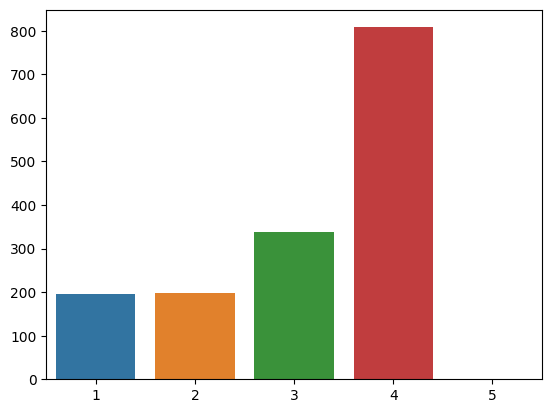

In [57]:
sns.barplot(x=[1,2,3,4,5], y=incorrect_count[4]) #so when it was supposed to be a 1 star reviews within 60 000 examples

In [28]:
incorrect_count = [[0 for _ in range(5)] for _ in range(5)]
print(*incorrect_count, sep = '\n')

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]


In [21]:
training_vis = pd.read_csv('training100correct.csv')
validation_vis = pd.read_csv('validation.csv')
training_vis.head()

,training loss,training accuracy,epoch
0,1.41,0.48,0
1,1.35,0.55,1
2,1.30,0.59,2
3,1.27,0.63,3
4,1.25,0.65,4


<AxesSubplot: xlabel='epoch', ylabel='training accuracy'>

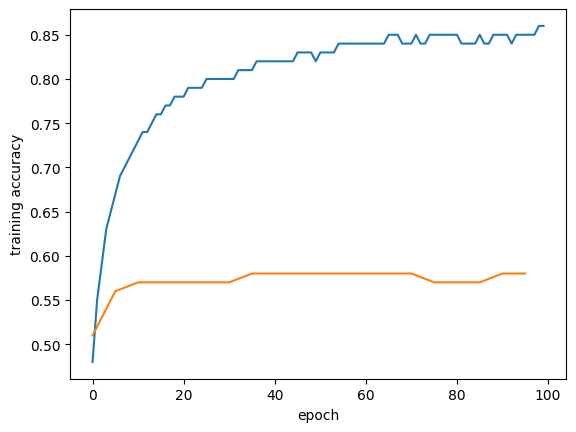

In [22]:
sns.lineplot(x = training_vis['epoch'], y = training_vis['training accuracy'])
sns.lineplot(x = validation_vis['epoch'], y = validation_vis['validation accuracy'])

<AxesSubplot: xlabel='epoch', ylabel='training loss'>

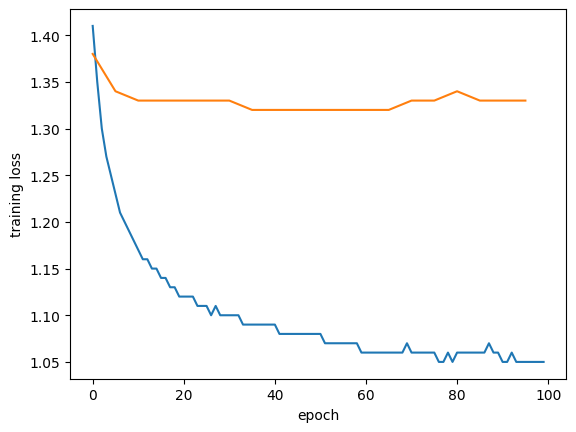

In [24]:
sns.lineplot(x = training_vis['epoch'], y = training_vis['training loss'])
sns.lineplot(x = validation_vis['epoch'], y = validation_vis['validation loss'])